# Package importing

In [1]:
## General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## preprocessing
from sklearn.preprocessing import MinMaxScaler

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Data import from github

In [2]:
credit_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/credit_record.csv")

In [3]:
app_data = pd.read_csv("https://raw.githubusercontent.com/jmoschos/Credit-score-approval/master/application_record.csv")

# Basic variable inspection

In [4]:
credit_data.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [5]:
app_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
len(app_data)

438557

In [7]:
len(credit_data)

1048575

# Labels 
In the dataset, no labels are given for "good" and "bad" customers. We will attempt to create new labels based on a vintage analysis. 

### Vintage analysis
In vintage analysis, If customer defaults (90 days or more past due) during the performance window, borrower would be considered as a 'bad' customer and labeled as 'event' in dependent variable.

In our dataset, the status is flagged as:
* 0 for 0-29 days
* 1 for 30-59 days
* 2 for 60-89 days
* 3 for 90-119 days
* 4 for 120-149 days
* 5 for 150+ days
* X for no Loan this month
* C for paid this month

If a user has more than 90 days overdue, we are going to flag him as "bad". Therefore, 0,1,2,X,C will be labelled as good and the rest as bad.

First, lets check the distribution amongst different categories:

In [8]:
## Percentage of records per status category
credit_data.groupby(["STATUS"]).agg(percent_per_category = ("STATUS","count"))*100/len(credit_data)

,percent_per_category
STATUS,
0,36.537205
1,1.057626
2,0.082779
3,0.030518
4,0.021267
5,0.161457
C,42.155401
X,19.953747


**Observation**: Majority of users are in the 0, C and X categories. 

Since the user (credit_score) file has multiple observations for each user, we are going to extract the initial month for each user:

In [9]:
# Finding the initial month for each user, as the minimum month in Balance grouped by user
initial_month_df = credit_data.groupby("ID").agg(
    initial_month = ("MONTHS_BALANCE",min)
)

In [10]:
credit_initial = pd.merge(credit_data,initial_month_df,how = "left", on=["ID"])

In [11]:
credit_initial["Label"]= np.where((credit_initial.STATUS == "4") | (credit_initial.STATUS =="5"), 1 , 0 )

In [12]:
credit_initial

,ID,MONTHS_BALANCE,STATUS,initial_month,Label
0,5001711,0,X,-3,0
1,5001711,-1,0,-3,0
2,5001711,-2,0,-3,0
3,5001711,-3,0,-3,0
4,5001712,0,C,-18,0
...,...,...,...,...,...
1048570,5150487,-25,C,-29,0
1048571,5150487,-26,C,-29,0
1048572,5150487,-27,C,-29,0
1048573,5150487,-28,C,-29,0


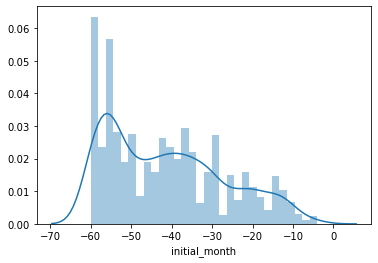

In [13]:
sns.distplot(credit_initial[credit_initial.Label==1].initial_month,bins=30)

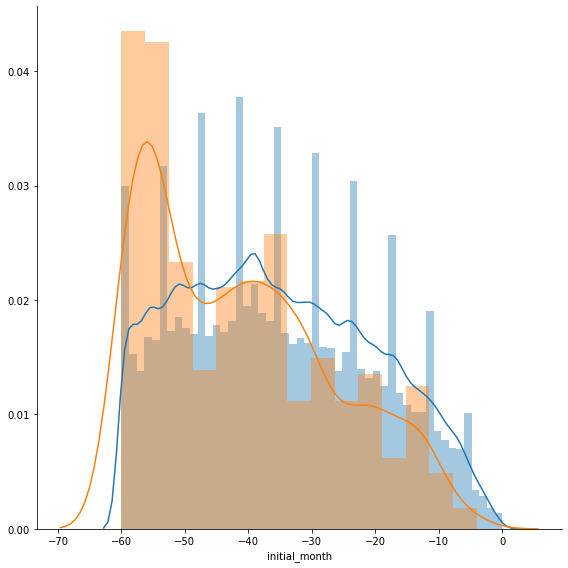

In [14]:
g = sns.FacetGrid(credit_initial, hue = "Label", height=8)
g = g.map(sns.distplot, "initial_month")

**Observation** While both the good and bad customers follow similar distributions, we see a huge spike on accounts that are 50 or more months old. These could potentially be test accounts used by the bank for operations.

It might be a good idea to exclude them from the analysis.

## Finalizing the labels for each user

Since each user can default at any moment in time, we will characterize him as bad if he had defaulted at least once in his time with the bank.

In [15]:
## Creation of table to merge with application data:

credit_to_merge = credit_initial.groupby(["ID"]).agg(
    initial_month = ("MONTHS_BALANCE",min),
    Label = ("Label",max)

)

In [16]:
credit_to_merge

,initial_month,Label
ID,,
5001711,-3,0
5001712,-18,0
5001713,-21,0
5001714,-14,0
5001715,-59,0
...,...,...
5150482,-28,0
5150483,-17,0
5150484,-12,0


In our final table, the percentage of "bad customers" is:

In [17]:
print(100*sum(credit_to_merge.Label)/len(credit_to_merge), "%")

0.5284331847341525 %


The dataset is very unbalanced, and will have to adjust for that later.

## Merging of datasets



We are going to merge the two tables by "ID" and keep only users who have been labeled in the previous steps.

In [18]:
data = pd.merge(app_data,credit_to_merge,on = "ID", how = "right")

In [19]:
data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45980,5122361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5,0
45981,5122362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5,0
45982,5122363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9,0
45983,5122364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-41,0


## Missing values

We are going to check for missing values:

In [20]:
missing = data.isnull().sum(axis = 1)

Since the data is so unbalanced, "good" customers missing a lot of data can be safely dropped. However, for customers characterized as "bad" (due to their number), we have to check if they can be "salvaged".

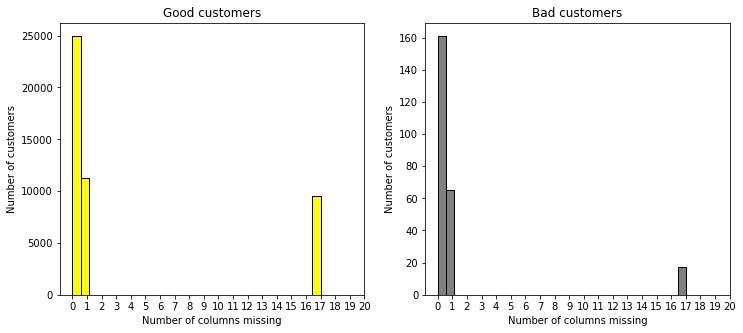

In [21]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
ax1.hist(missing[data.Label ==0],bins = 30,edgecolor = "black", color = "yellow")
plt.title("Good customers")
plt.xlabel("Number of columns missing")
plt.ylabel("Number of customers")
plt.xticks(ticks=np.arange(0,21,1))

ax2 = plt.subplot(1,2,2)
ax2.hist(missing[data.Label ==1],bins = 30,edgecolor = "black",color = "grey")

plt.title("Bad customers")
plt.xlabel("Number of columns missing")
plt.ylabel("Number of customers")
plt.xticks(ticks=np.arange(0,21,1))
plt.show()

In [22]:
print("The number of bad customers with missing all data is: ", sum((missing >= 17) & (data.Label ==1)))
print("The number of good customers with missing all data is: ", sum((missing >= 17) & (data.Label ==0)))

The number of bad customers with missing all data is:  17
The number of good customers with missing all data is:  9511


We are going to drop the rows (both good and bad customers) that have all the data missing and we are going to fix those that have only 1 column missing.

In [23]:
new_data = data.drop(data[missing>=17].index)

In [24]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,NaN,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,-11,1
36453,5149834,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-23,1
36454,5149838,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-32,1
36455,5150049,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,-9,0


Let's observe what else has NA values:

In [25]:
new_data.isna().sum(axis = 0)

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
initial_month              0
Label                      0
dtype: int64

**Observation** Only the occupation type has missing values from all the columns. It appears that the bank always captures the rest of information for their clients. 

Unique occupation categories:

In [26]:
new_data.OCCUPATION_TYPE.unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

We are going to treat NAs as a unique category in our analysis!

In [27]:
new_data.OCCUPATION_TYPE[new_data.OCCUPATION_TYPE.isna().index]

0                   NaN
1                   NaN
2        Security staff
3           Sales staff
4           Sales staff
              ...      
36452          Managers
36453    Medicine staff
36454    Medicine staff
36455       Sales staff
36456          Laborers
Name: OCCUPATION_TYPE, Length: 36457, dtype: object

In [28]:
sum(new_data.OCCUPATION_TYPE.isna())

11323

In [29]:
new_data.OCCUPATION_TYPE = new_data.OCCUPATION_TYPE.fillna(value="Missing")

In [30]:
sum(new_data.OCCUPATION_TYPE.isna())

0

In [31]:
new_data

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,5008804,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-15,0
1,5008805,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-14,0
2,5008806,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,5008808,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,5008809,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,-11,1
36453,5149834,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-23,1
36454,5149838,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-32,1
36455,5150049,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,-9,0


#  Exploratory Data analysis

In this section, we will explore the different variables and the relationship with our target variable.

Lets start by dropping the ID variable that will not be needed for our models.

In [32]:
new_data = new_data.drop("ID",axis = 1)
new_data

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,initial_month,Label
0,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-15,0
1,M,Y,Y,0.0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005.0,-4542.0,1.0,1.0,0.0,0.0,Missing,2.0,-14,0
2,M,Y,Y,0.0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474.0,-1134.0,1.0,0.0,0.0,0.0,Security staff,2.0,-29,0
3,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-4,0
4,F,N,Y,0.0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110.0,-3051.0,1.0,0.0,1.0,1.0,Sales staff,1.0,-26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,M,Y,Y,0.0,315000.0,Working,Secondary / secondary special,Married,House / apartment,-17348.0,-2420.0,1.0,0.0,0.0,0.0,Managers,2.0,-11,1
36453,F,N,Y,0.0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-23,1
36454,F,N,Y,0.0,157500.0,Pensioner,Higher education,Married,House / apartment,-12387.0,-1325.0,1.0,0.0,1.0,1.0,Medicine staff,2.0,-32,1
36455,F,N,Y,0.0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958.0,-655.0,1.0,0.0,0.0,0.0,Sales staff,2.0,-9,0


In [33]:
unique_labels = new_data.Label.unique()
labels = [new_data[new_data.Label == val] for val in unique_labels]

In [71]:
my_colors = ["denim blue","pale red"]

## Gender analysis 

In [34]:
unique_genders = new_data.CODE_GENDER.unique() ## just making sure only 2 genders exist

In [35]:
genders = [new_data[new_data.CODE_GENDER==gender] for gender in unique_genders]
    

In [36]:
for gender in genders:
    print("Gender: ", gender.CODE_GENDER.unique())
    print("Number of customers:", len(gender))
    print("Percentage of good customers", sum(gender.Label ==0)/len(gender))
    print("Percentage of bad customers", sum(gender.Label == 1)/len(gender))

Gender:  ['M']
Number of customers: 12027
Percentage of good customers 0.9921842520994429
Percentage of bad customers 0.00781574790055708
Gender:  ['F']
Number of customers: 24430
Percentage of good customers 0.994596807204257
Percentage of bad customers 0.005403192795742939


**Observation** Men appear slightly more prone to defaulting than women, but they also consist of 1/3 of the total population.

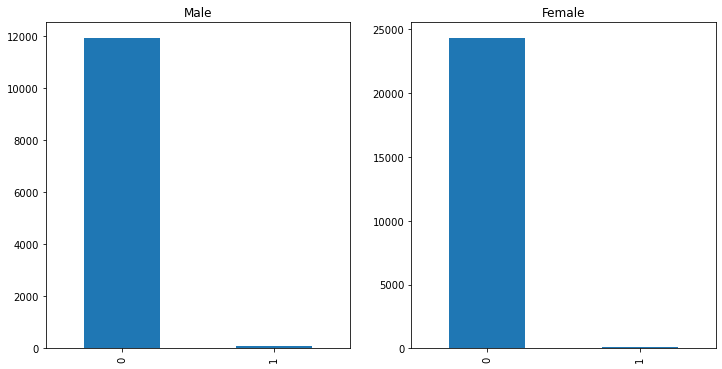

In [37]:
nrows = 1
ncols = 2

# Here axes contains 2 objects representing the two subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))

for i,gender in enumerate(genders):
    gender['Label'].value_counts().plot(kind = 'bar', ax = axes[i])
    axes[i].set_title("Male" if gender.CODE_GENDER.unique() == "M" else "Female")

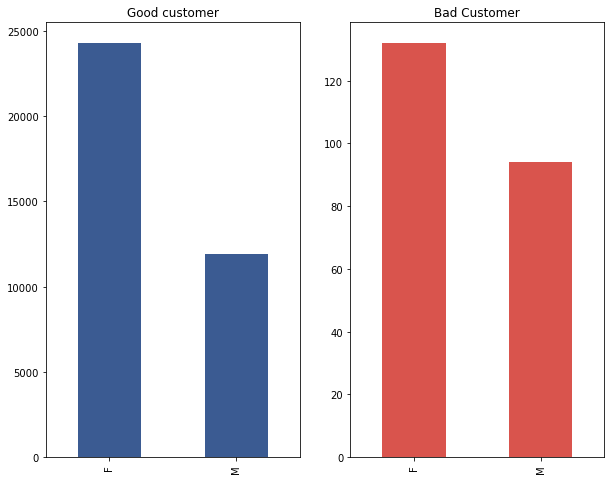

In [80]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize = (10,8))

for i,label in enumerate(labels):
    label.CODE_GENDER.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if(label.Label.unique()==0) else "Bad Customer")

## Having a car 

In [39]:
unique_cars = new_data.FLAG_OWN_CAR.unique()
cars = [new_data[new_data.FLAG_OWN_CAR==car] for car in unique_cars]

In [40]:

for car in cars:
    print("Has Car: ", car.FLAG_OWN_CAR.unique())
    print("Number of customers:", len(car))
    print("Percentage of good customers", sum(car.Label ==0)/len(car))
    print("Percentage of bad customers", sum(car.Label == 1)/len(car))

Has Car:  ['Y']
Number of customers: 13843
Percentage of good customers 0.9942931445495918
Percentage of bad customers 0.0057068554504081485
Has Car:  ['N']
Number of customers: 22614
Percentage of good customers 0.9934996020164499
Percentage of bad customers 0.006500397983550013


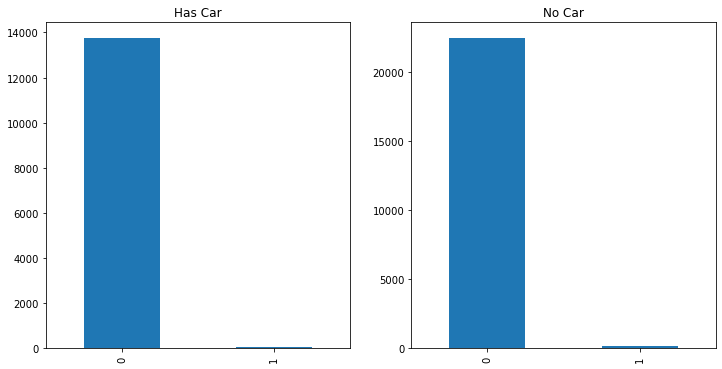

In [41]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize =(12,6))

for i,car in enumerate(cars):
    car.Label.value_counts().plot(kind = "bar", ax = axes[i])
    axes[i].set_title("Has Car" if(car.FLAG_OWN_CAR.unique()=="Y") else "No Car")
    
plt.show()

**Observation** Not having a car is associated with slightly more bad customers.

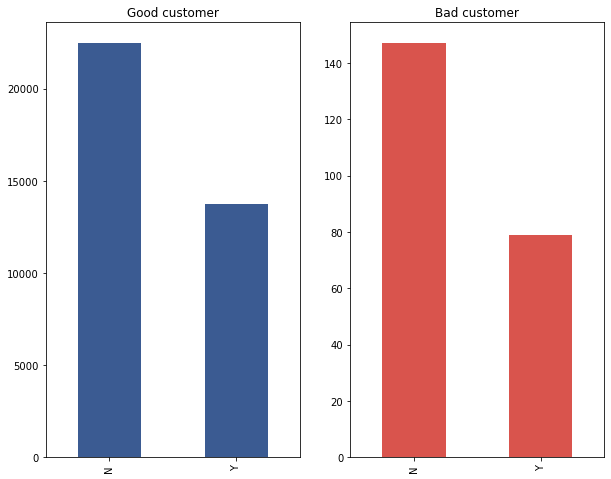

In [79]:
nrow = 1
ncol = 2

fig, axes = plt.subplots(nrow,ncol, figsize = (10,8))

for i,label in enumerate(labels):
    label.FLAG_OWN_CAR.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label.Label.unique()==0 else "Bad customer")

### Having a property

In [43]:
unique_properties = new_data.FLAG_OWN_REALTY.unique()
properties = [new_data[new_data.FLAG_OWN_REALTY == val] for val in unique_properties]

In [44]:
for val in properties:
    print("Has Car: ", val.FLAG_OWN_REALTY.unique())
    print("Number of customers:", len(val))
    print("Good customers percentage:",val.Label[val.Label ==0].count()/len(val))
    print("Bad customers percentage:",val.Label[val.Label ==1].count()/len(val))

Has Car:  ['Y']
Number of customers: 24506
Good customers percentage: 0.9942463070268506
Bad customers percentage: 0.005753692973149433
Has Car:  ['N']
Number of customers: 11951
Good customers percentage: 0.9928876244665719
Bad customers percentage: 0.007112375533428165


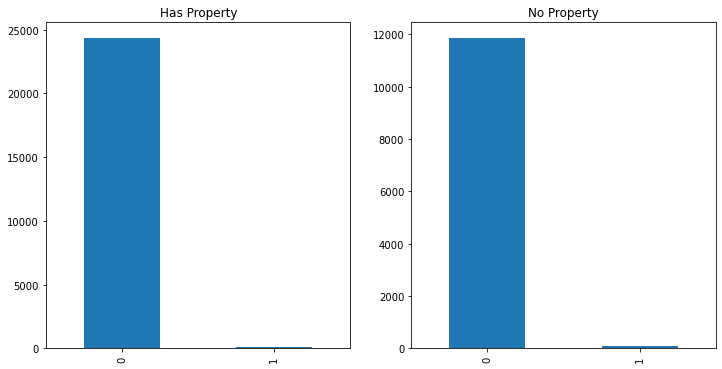

In [45]:
nrow = 1
ncol = 2

fig, axes = plt.subplots(nrows=nrow,ncols=ncol,figsize=(12,6))

for i,val in enumerate(properties):
    val.Label.value_counts().plot(kind = "bar", ax = axes[i])
    axes[i].set_title("Has Property" if(val.FLAG_OWN_REALTY.unique()=="Y") else "No Property")

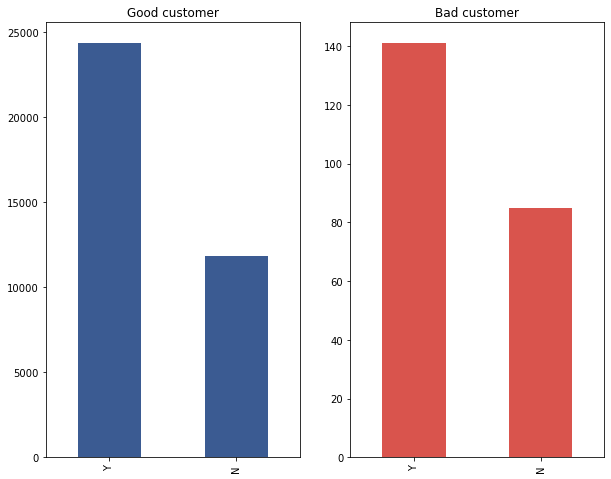

In [78]:
nrows = 1
ncols = 2

fig, axes = plt.subplots(nrows,ncols,figsize = (10,8))

for i,label in enumerate(labels):
    label.FLAG_OWN_REALTY.value_counts().plot(kind = "bar", ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label.Label.unique()==0 else "Bad customer")

**Observation** Not having an estate is associated with slightly more "bad" customers.

### Number of children

In [47]:
unique_children = new_data.CNT_CHILDREN.unique()
unique_children = np.sort(unique_children)
print(unique_children)

[ 0.  1.  2.  3.  4.  5.  7. 14. 19.]


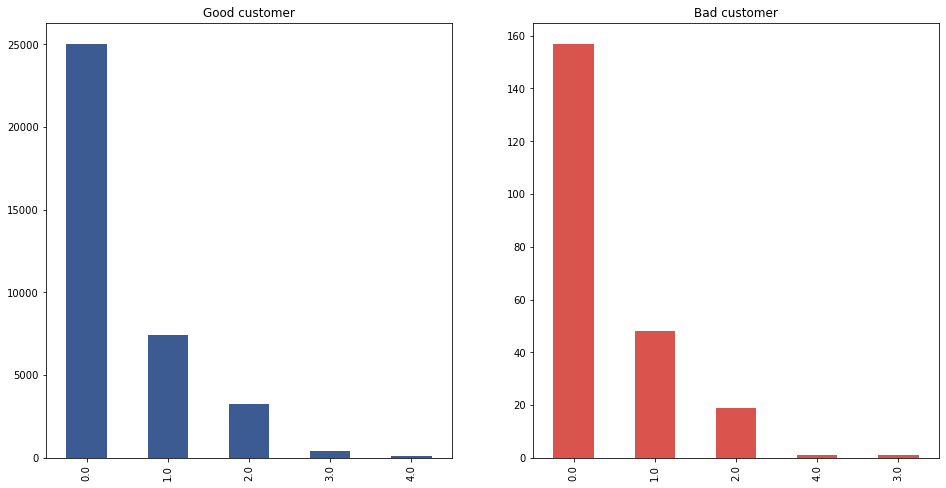

In [77]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_CHILDREN.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

**Observation** Number of children appears to have some strange values (14, 19) and very few observations for them. We are going to convert the number of children to a categorical feature and for all values >=4 convert them to "4+".

In [49]:
new_data.CNT_CHILDREN = np.where(new_data.CNT_CHILDREN>=4, 4 ,new_data.CNT_CHILDREN)

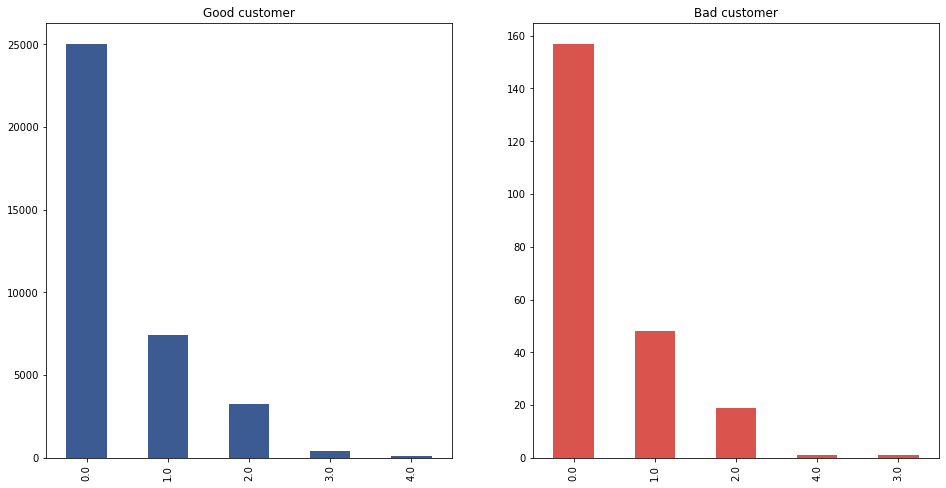

In [76]:
nrows = 1
ncols = len(unique_labels)

fig,axes = plt.subplots(nrows,ncols, figsize = (16,8))

for i,label in enumerate(unique_labels):
    new_data[new_data.Label == label].CNT_CHILDREN.value_counts().plot(kind = "bar",ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_title("Good customer" if label == 0 else "Bad customer")

### Annual income

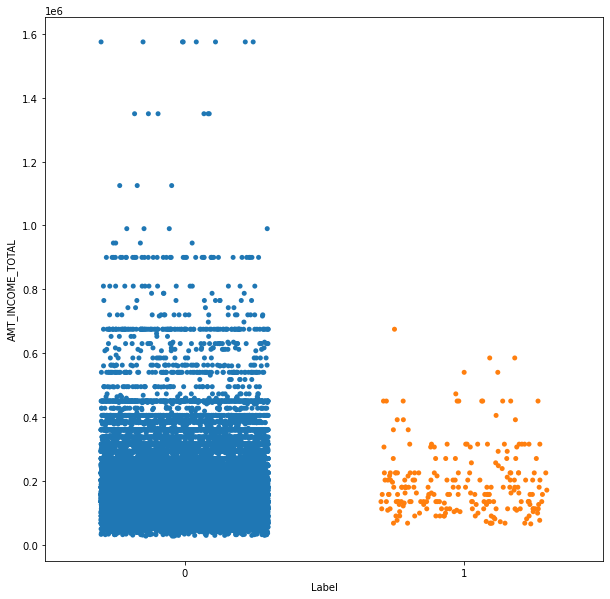

In [83]:
plt.figure(figsize=(10,10))
sns.stripplot(x = new_data.Label, y = new_data.AMT_INCOME_TOTAL, jitter = 0.3)

**Observation** It looks like lower incomes are associated more with bad customer rates.

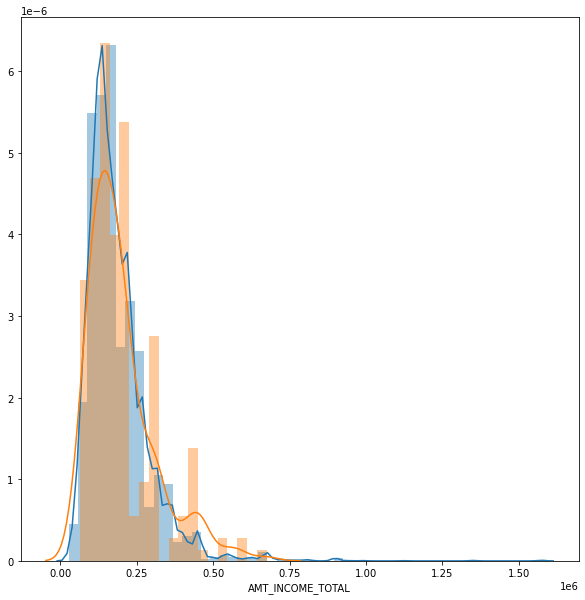

In [84]:
plt.figure(figsize=(10,10))

for label in unique_labels:
    sns.distplot(new_data.AMT_INCOME_TOTAL[new_data.Label==label])

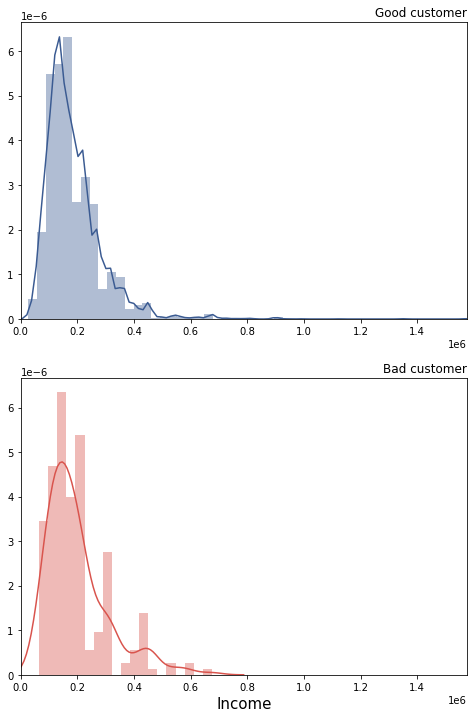

In [75]:
nrows = 2
ncols = 1

fig,axes = plt.subplots(nrows,ncols,figsize = (8,12))

for i, label in enumerate(unique_labels):
    sns.distplot(new_data.AMT_INCOME_TOTAL[new_data["Label"]==label],ax = axes[i],color = sns.xkcd_rgb[my_colors[i]])
    axes[i].set_xlim(0,max(new_data["AMT_INCOME_TOTAL"]))
    axes[i].set_title("Good customer" if label ==0 else "Bad customer", loc = "right")
    axes[i].set_xlabel("Income" if label ==1 else "", fontsize = 15)

## Feature selection

In [ ]:
new_data

In [ ]:
a = pd.get_dummies(new_data, columns=["CODE_GENDER","FLAG_OWN_CAR","FLAG_OWN_REALTY", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE","NAME_FAMILY_STATUS","NAME_HOUSING_TYPE", "OCCUPATION_TYPE" ])

In [ ]:
a

In [ ]:
a=a.drop(["initial_month","DAYS_BIRTH"],axis = 1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(a.drop(["Label"],axis = 1),a.Label,test_size = 0.2)

In [ ]:
X_train

## Model development and evaluation

### Logistic regression

In [ ]:
Logit = LogisticRegression()

fit_log = Logit.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_log.predict(X_test))

In [ ]:
confusion_matrix(y_pred,Y_test)

### Random Forest

In [ ]:
RF = RandomForestClassifier()

fit_rf = RF.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_rf.predict(X_test))

In [ ]:
confusion_matrix(y_pred,Y_test)

### XG Boost

In [ ]:
param_grid = {'max_depth': range(4,6),
              'n_estimators': range(500,1000,100)}

In [ ]:
xgb = GridSearchCV(XGBClassifier(nthread = -1),param_grid,cv = 5,verbose=2)

fit_xgb = xgb.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_xgb.predict(X_test))

In [ ]:
fit_xgb.best_params_

In [ ]:
xg = XGBClassifier()

fit_xgb = xg.fit(X_train,Y_train)

y_pred = pd.DataFrame(fit_xgb.predict(X_test))


In [ ]:
confusion_matrix(y_pred,Y_test)